In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import parent
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import data


In [6]:

BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
working_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net = inverseConsistentNet.InverseConsistentAffineDeformableNet(
    networks.ConvolutionalMatrixNet(dimension=3),
    networks.tallUNet2(dimension=3),
    lmbda=100,
    input_shape=working_shape,
)

net.load_state_dict(torch.load("../results/aff_def_knee7/knee_aligner_resi_net2700"))

/playpen-raid1/tgreer/InverseConsistency/networks.py:390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


<All keys matched successfully>

In [7]:
_, medresknees = data.get_knees_dataset()

In [11]:
net.cuda()

InverseConsistentAffineDeformableNet(
  (affine_regis_net): ConvolutionalMatrixNet(
    (convs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (5): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (dense2): Linear(in_features=512, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=12, bias=True)
  )
  (regis_net): UNet2(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      

In [8]:
def make_batch():
    image = torch.cat([random.choice(medresknees) for _ in range(BATCH_SIZE)])
    image = image[:, None]
    image = image.cuda()
    return image

In [9]:
moving_image, fixed_image = make_batch(), make_batch()

In [12]:
net(moving_image, fixed_image)

[tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0022, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1602, device='cuda:0', grad_fn=<MulBackward0>)]

In [13]:
net.matrix_AB

tensor([[[ 9.7836e-01,  1.3821e-02,  8.3851e-03, -5.2522e-03],
         [ 2.1518e-02,  1.0459e+00, -1.5749e-02,  8.1090e-03],
         [-1.7399e-03, -3.3916e-02,  9.5737e-01,  1.2443e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.9694e-01, -1.4745e-03, -1.7050e-03, -1.9924e-04],
         [ 3.3228e-03,  9.9502e-01, -2.5484e-04,  2.0221e-03],
         [-1.7418e-03,  5.2544e-04,  1.0000e+00, -3.6552e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.7122e-01,  1.1528e-03, -7.8252e-03, -4.5240e-03],
         [ 1.0412e-02,  1.0029e+00, -1.8022e-02,  7.9478e-03],
         [-2.2287e-02,  7.3083e-02,  1.0233e+00, -1.8054e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0015e+00,  3.8853e-03,  4.6856e-03,  1.8531e-02],
         [-1.8514e-03,  9.8324e-01,  2.2061e-03,  1.6738e-05],
         [ 8.0775e-03, -1.7716e-02,  9.7152e-01,  2.7803e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

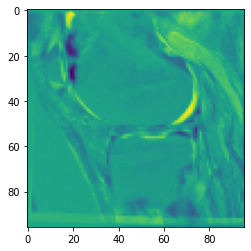

In [18]:
plt.imshow(fixed_image[0, 0, 10].cpu() - net.warped_image_A[0, 0, 10].cpu().detach())

##plt.imshow(net.warped_image_A[0, 0, 10].cpu().detach())
#plt.show()
#plt.imshow(net.warped_image_B[0, 0, 10].cpu().detach())

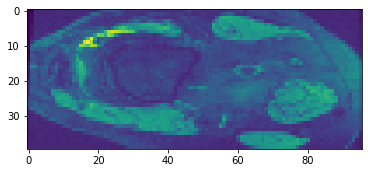

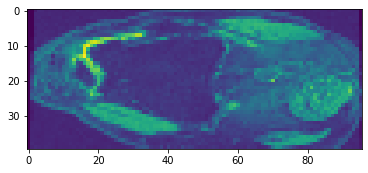

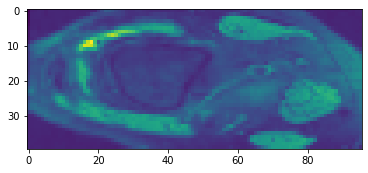

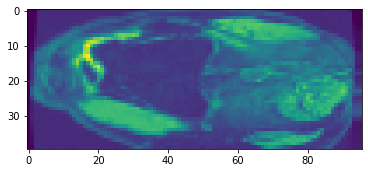

In [15]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

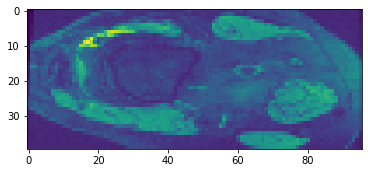

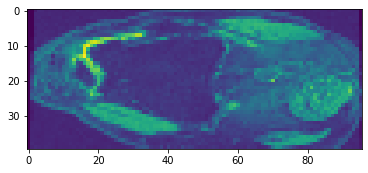

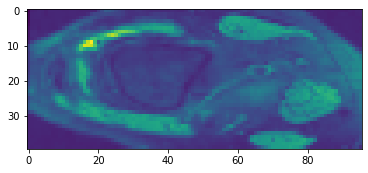

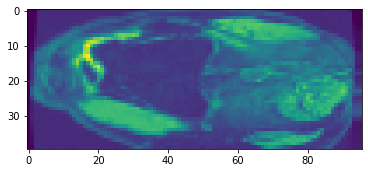

In [16]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())

In [50]:
net.matrix_AB[20].cpu().detach().numpy()

array([[ 0.97595763,  0.00672266,  0.00006951, -0.01163099],
       [ 0.03015379,  1.0754728 , -0.03506744,  0.01556389],
       [ 0.00235689, -0.02747279,  0.955216  ,  0.05459239],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [49]:
import numpy as np
np.set_printoptions(suppress=True)

In [23]:
len(list(net.parameters()))

48

In [27]:
next(net.parameters()).requires_grad

True

In [29]:
len(list(net.affine_regis_net.parameters()))

16

In [31]:
for p in net.affine_regis_net.parameters():
    p.requires_grad = False

In [32]:
[p.requires_grad for p in net.parameters()]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]